## Import lib

In [1]:
import pandas as pd
import numpy as np
import os, warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# evaluation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# metric
from sklearn.metrics import mean_squared_error, r2_score

## Import data

In [3]:
df = pd.read_csv('../data/clean_data.csv')

In [4]:
df.isna().sum()[df.isna().sum() > 0]

numberof_floors       2
energystar_score    672
dtype: int64

In [5]:
seed = 42

## Utils

In [6]:
def data_selection(data:pd.DataFrame, target:str, skip_features:list, stratify:str=None, test_size:float=.2, random_state:int=0):
    
    X = data.drop(columns = [target] + skip_features)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [7]:
def model_selection(data:pd.DataFrame, target:str, skip_features:list, preprocessing_pipeline, models_dict:dict, preprocessing_param_grid:dict={}, cv_n_splits:int=5, stratify:str=None, test_size:float=.2, random_state:int=0, chart:bool=True, verbosity:int=0):
        
    X_train, X_test, y_train, y_test = data_selection(data, target, skip_features, stratify, test_size, random_state)
    
    cv = KFold(n_splits=cv_n_splits, shuffle = True, random_state=0)
    
    result_df = pd.DataFrame(columns = models_dict.keys())
    
    for key, values in models_dict.items():
                
        model = values.get('model')
        model_param_grid=values.get('param_grid')
        param_grid = dict(list(preprocessing_param_grid.items()) + list(model_param_grid.items()))
        pipe=Pipeline((('preprocessing', preprocessing_pipeline), ('model', model)))
        
        locals()[key] = GridSearchCV(pipe, param_grid, cv=cv, scoring='neg_root_mean_squared_error', verbose=verbosity)
        locals()[key].fit(X_train, y_train)
        y_pred=locals()[key].best_estimator_.predict(X_test)
        rmse=mean_squared_error(y_test, y_pred, squared=False)
        r2=r2_score(y_test, y_pred)
        
        result_df.loc['rmse', key] = rmse
        result_df.loc['r2', key] = r2
        
        for param in locals()[key].best_params_:
            result_df.loc[param, key] = locals()[key].best_params_[param]
        
        if chart:
            fig, ax = plt.subplots()
            ax.scatter(y_test, y_pred, marker='.')
            ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
            ax.set_xlabel('Measured')
            ax.set_ylabel('Predicted')
            plt.title(key)
            plt.show()
        
    display(result_df)
    
    return locals()[result_df.loc['rmse'].astype(float).idxmin()]

## GHG emissions

In [8]:
df_ghg_emissions_intensity = df.drop(columns=['site_energy_use_wn', 'site_energy_use_wn_log'])
df_ghg_emissions_intensity.shape

(2032, 97)

### Target preprocessing

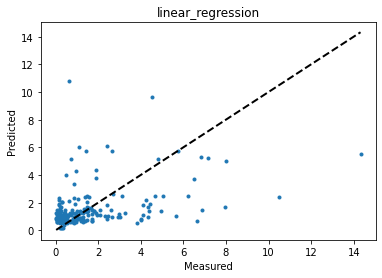

,linear_regression
rmse,1.94516
r2,0.0650317


In [9]:
target='ghg_emissions_intensity'
skip_features=['energystar_score', 'ghg_emissions_intensity_log']

num_features = df_ghg_emissions_intensity.columns[~df_ghg_emissions_intensity.columns.str.contains('cat_')]
num_features = num_features[~np.isin(num_features, [target]+skip_features)].tolist()

num_preprocessing = Pipeline((
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('normalizer', 'passthrough'),
    ('scaler', 'passthrough')
), verbose = False)

preprocessing = ColumnTransformer([('num_preprocessing', num_preprocessing, num_features)])

models_dict = {
    'linear_regression': {
        'model': LinearRegression(),
        'param_grid': {}}}

best_estimator = model_selection(
    df_ghg_emissions_intensity, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    random_state=seed,
    test_size=0.1,
    chart=True
)

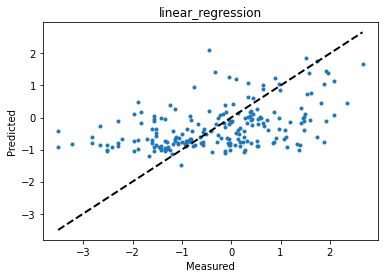

,linear_regression
rmse,1.11313
r2,0.208138


In [10]:
target='ghg_emissions_intensity_log'
skip_features=['energystar_score', 'ghg_emissions_intensity']

num_features = df_ghg_emissions_intensity.columns[~df_ghg_emissions_intensity.columns.str.contains('cat_')]
num_features = num_features[~np.isin(num_features, [target]+skip_features)].tolist()

num_preprocessing = Pipeline((
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('normalizer', 'passthrough'),
    ('scaler', 'passthrough')
), verbose = False)

preprocessing = ColumnTransformer([('num_preprocessing', num_preprocessing, num_features)])

models_dict = {
    'linear_regression': {
        'model': LinearRegression(),
        'param_grid': {}}}

best_estimator = model_selection(
    df_ghg_emissions_intensity, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    random_state=seed,
    test_size=0.1,
    chart=True
)

### Model selection

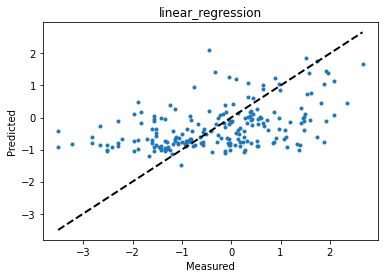

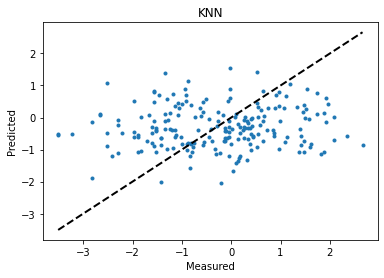

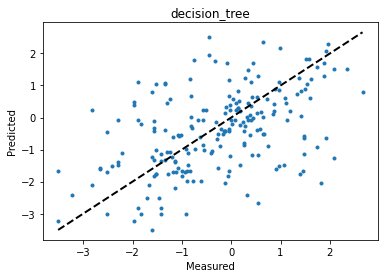

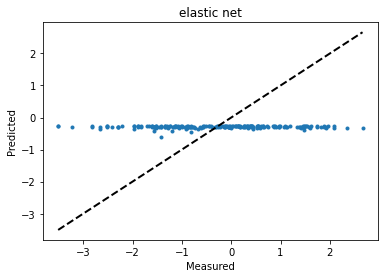

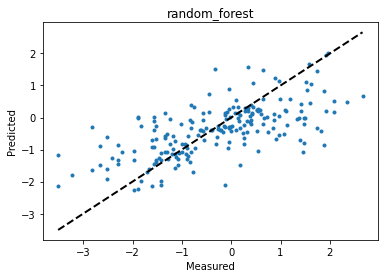

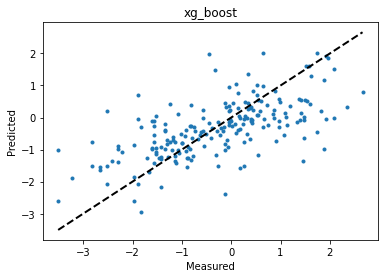

,linear_regression,KNN,decision_tree,elastic net,random_forest,xg_boost
rmse,1.11313,1.36625,1.28339,1.24973,0.941893,0.974768
r2,0.208138,-0.192937,-0.0526243,0.00187369,0.433033,0.392765


In [11]:
target='ghg_emissions_intensity_log'
skip_features=['energystar_score', 'ghg_emissions_intensity']

num_features = df_ghg_emissions_intensity.columns[~df_ghg_emissions_intensity.columns.str.contains('cat_')]
num_features = num_features[~np.isin(num_features, [target]+skip_features)].tolist()

num_preprocessing = Pipeline((
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('normalizer', 'passthrough'),
    ('scaler', 'passthrough')
), verbose = False)

preprocessing = ColumnTransformer([('num_preprocessing', num_preprocessing, num_features)])

models_dict = {
    'linear_regression': {
        'model': LinearRegression(),
        'param_grid': {},    
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'param_grid': {},    
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(random_state= seed),
        'param_grid': {},    
    },   
    'elastic net': {
        'model': ElasticNet(random_state = seed),
        'param_grid': {},
    },
    'random_forest': {
        'model': RandomForestRegressor(random_state = seed),
        'param_grid': {},  
    },
    'xg_boost': {
    'model': XGBRegressor(random_state = seed),
    'param_grid': {},
    },
}

best_estimator_ghg_emissions_intensity = model_selection(
    df_ghg_emissions_intensity, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    random_state=seed,
    test_size=0.1,
    chart=True
)

### Preprocessing optimization

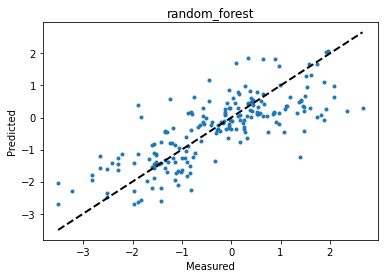

,random_forest
rmse,0.808204
r2,0.582558
preprocessing__num_preprocessing__normalizer,passthrough
preprocessing__num_preprocessing__scaler,MinMaxScaler()
preprocessing__remainder,passthrough


In [12]:
target='ghg_emissions_intensity_log'
skip_features=['energystar_score', 'ghg_emissions_intensity']

num_features = df_ghg_emissions_intensity.columns[~df_ghg_emissions_intensity.columns.str.contains('cat_')]
num_features = num_features[~np.isin(num_features, [target]+skip_features)].tolist()

num_preprocessing = Pipeline((
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('normalizer', 'passthrough'),
    ('scaler', 'passthrough')
), verbose = False)

preprocessing = ColumnTransformer([('num_preprocessing', num_preprocessing, num_features)])

models_dict = {'random_forest':{
    'model': RandomForestRegressor(random_state = seed),
    'param_grid': {},
    },
}

preprocessing_param_grid = {
    'preprocessing__remainder': ['passthrough', 'drop'],
    'preprocessing__num_preprocessing__normalizer': ['passthrough', FunctionTransformer(lambda x: np.log(np.abs(x)+1))],
    'preprocessing__num_preprocessing__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
}

best_estimator_ghg_emissions_intensity = model_selection(
    df_ghg_emissions_intensity, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    preprocessing_param_grid=preprocessing_param_grid,
    random_state=seed,
    test_size=0.1,
    chart=True
)

### Fine tuning

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.3min finished


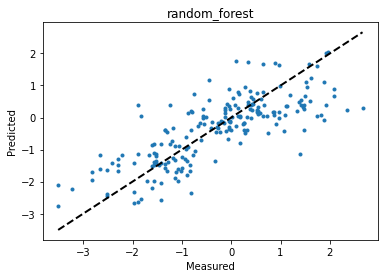

,random_forest
rmse,0.797505
r2,0.593537
model__ccp_alpha,0
model__max_depth,None
model__max_features,auto
model__n_estimators,300


CPU times: user 4min 58s, sys: 3.63 s, total: 5min 2s
Wall time: 5min 21s


In [18]:
%%time
target='ghg_emissions_intensity_log'
skip_features=['energystar_score', 'ghg_emissions_intensity']

models_dict = {'random_forest':{
    'model': RandomForestRegressor(random_state = seed),
    'param_grid':{'model__n_estimators': [50, 100, 300],
                   'model__max_depth': [6, None], 
                   'model__max_features':['auto', 'sqrt', 'log2'],
                   'model__ccp_alpha': [0.0, 0.2, 1.0]
                 }}}
              
best_estimator_ghg_emissions_intensity = model_selection(
    df_ghg_emissions_intensity, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=best_estimator_ghg_emissions_intensity.best_estimator_['preprocessing'],
    models_dict=models_dict,
    random_state=seed,
    test_size=0.1,
    chart=True,
    verbosity=1
)

### Feature importances

In [19]:
target='ghg_emissions_intensity_log'
skip_features=['energystar_score', 'ghg_emissions_intensity']

X_train, X_test, y_train, y_test = data_selection(df_ghg_emissions_intensity, target, skip_features)
feature_importances = pd.DataFrame({'feature':X_train.columns, 'importance': best_estimator_ghg_emissions_intensity.best_estimator_['model'].feature_importances_})

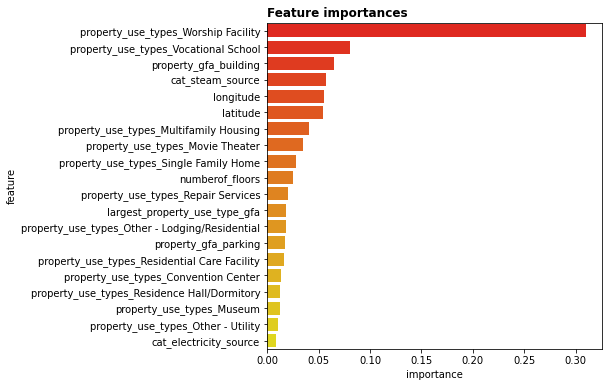

In [20]:
plt.figure(figsize=(6, 6))
sns.barplot('importance', 'feature', data=feature_importances.sort_values('importance', ascending = False).iloc[:20], palette='autumn')
plt.title('Feature importances', loc='left', weight='bold')
plt.show()

### Error analysis

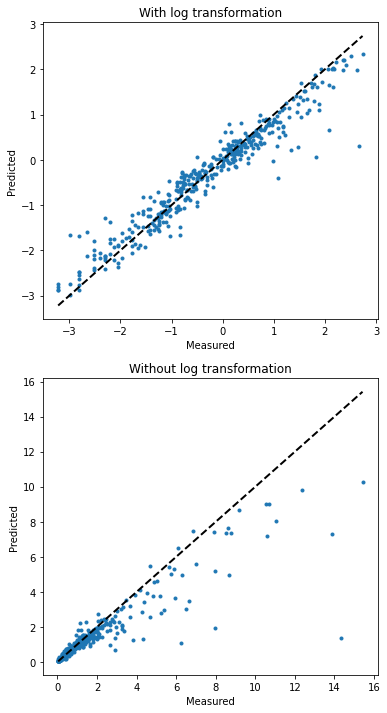

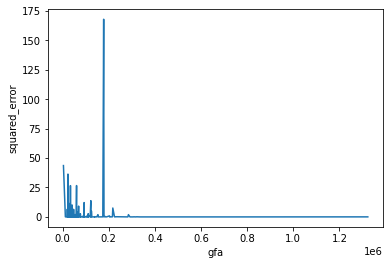

In [21]:
target='ghg_emissions_intensity_log'
skip_features=['energystar_score', 'ghg_emissions_intensity']
X_train_log, X_test_log, y_train_log, y_test_log = data_selection(df_ghg_emissions_intensity, target, skip_features)

target='ghg_emissions_intensity'
skip_features=['energystar_score', 'ghg_emissions_intensity_log']
X_train, X_test, y_train, y_test = data_selection(df_ghg_emissions_intensity, target, skip_features)

y_pred_log = pd.Series(best_estimator_ghg_emissions_intensity.best_estimator_.predict(X_test_log))
y_pred = np.exp(y_pred_log)

gfa = X_test.property_gfa_building.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_test_log = y_test_log.reset_index(drop=True)

results_df = pd.concat([y_test, y_test_log, y_pred, y_pred_log, gfa], axis=1, ignore_index=True)
results_df.columns = ['test', 'test_log', 'pred', 'pred_log', 'gfa']
results_df.sort_values('test', inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(6, 12))
ax[0].scatter(results_df.test_log, results_df.pred_log, marker='.')
ax[0].plot([results_df.test_log.min(), results_df.test_log.max()], [results_df.test_log.min(), results_df.test_log.max()], 'k--', lw=2)
ax[0].set_xlabel('Measured')
ax[0].set_ylabel('Predicted')
ax[0].title.set_text('With log transformation')

ax[1].scatter(results_df.test, results_df.pred, marker='.')
ax[1].plot([results_df.test.min(), results_df.test.max()], [results_df.test.min(), results_df.test.max()], 'k--', lw=2)
ax[1].set_xlabel('Measured')
ax[1].set_ylabel('Predicted')
ax[1].title.set_text('Without log transformation')

plt.show()

results_df['squared_error_log'] = (results_df.pred_log - results_df.test_log) ** 2
results_df['squared_error'] = (results_df.pred - results_df.test) ** 2
sns.lineplot(x = 'gfa', y= 'squared_error', data = results_df.sort_values('gfa'))
plt.show()

### With Energystar score

In [22]:
df_ghg_emissions_intensity_energystar_score = df_ghg_emissions_intensity.loc[df_ghg_emissions_intensity.energystar_score.notna()]
df_ghg_emissions_intensity_energystar_score.shape

(1360, 97)

In [28]:
models_dict = {'random_forest':{'model': best_estimator_ghg_emissions_intensity.best_estimator_['model'], 'param_grid': {}}}

model = model_selection(
    df_ghg_emissions_intensity_energystar_score, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=best_estimator_ghg_emissions_intensity.best_estimator_['preprocessing'],
    models_dict=models_dict,
    preprocessing_param_grid={},
    random_state=seed,
    chart=False,
    verbosity=1
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.6s finished


,random_forest
rmse,0.609493
r2,0.742995


## Site energy use wn

In [29]:
df_site_energy_use_wn = df.drop(columns=['ghg_emissions_intensity', 'ghg_emissions_intensity_log'])
df_site_energy_use_wn.shape

(2032, 97)

### Target preprocessing

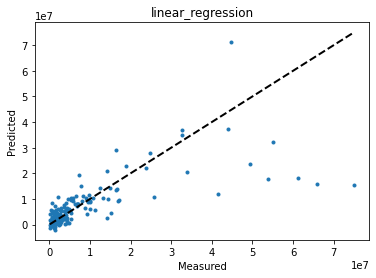

,linear_regression
rmse,8.34662e+06
r2,0.519042


In [30]:
target='site_energy_use_wn'
skip_features=['energystar_score', 'site_energy_use_wn_log']

num_features = df_site_energy_use_wn.columns[~df_site_energy_use_wn.columns.str.contains('cat_')]
num_features = num_features[~np.isin(num_features, [target]+skip_features)].tolist()

num_preprocessing = Pipeline((
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('normalizer', 'passthrough'),
    ('scaler', 'passthrough')
), verbose = False)

preprocessing = ColumnTransformer([('num_preprocessing', num_preprocessing, num_features)])

models_dict = {
    'linear_regression': {
        'model': LinearRegression(),
        'param_grid': {}}}

best_estimator = model_selection(
    df_site_energy_use_wn, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    random_state=seed,
    test_size=0.1,
    chart=True
)

In [ ]:
target='site_energy_use_wn_log'
skip_features=['energystar_score', 'site_energy_use_wn']

num_features = df_site_energy_use_wn.columns[~df_site_energy_use_wn.columns.str.contains('cat_')]
num_features = num_features[~np.isin(num_features, [target]+skip_features)].tolist()

num_preprocessing = Pipeline((
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('normalizer', 'passthrough'),
    ('scaler', 'passthrough')
), verbose = False)

preprocessing = ColumnTransformer([('num_preprocessing', num_preprocessing, num_features)])

models_dict = {
    'linear_regression': {
        'model': LinearRegression(),
        'param_grid': {}}}

best_estimator = model_selection(
    df_site_energy_use_wn, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    random_state=seed,
    test_size=0.1,
    chart=True
)

### Model selection

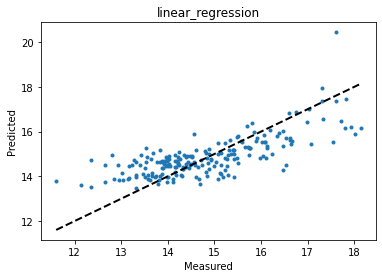

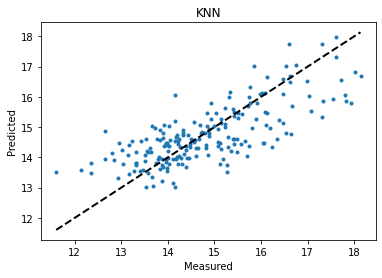

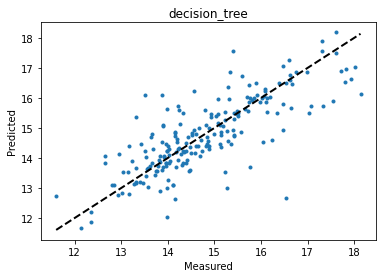

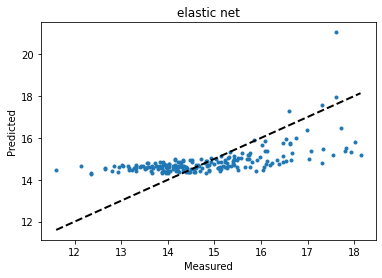

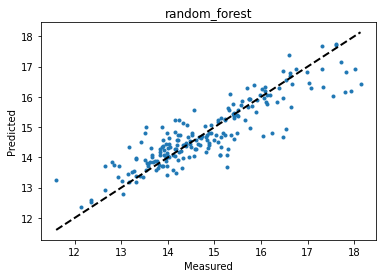

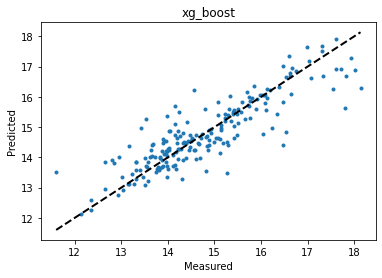

,linear_regression,KNN,decision_tree,elastic net,random_forest,xg_boost
rmse,0.855085,0.848187,0.829476,1.03542,0.590346,0.630036
r2,0.549126,0.556371,0.575728,0.338898,0.785093,0.755225


In [31]:
target='site_energy_use_wn_log'
skip_features=['energystar_score', 'site_energy_use_wn']

num_features = df_site_energy_use_wn.columns[~df_site_energy_use_wn.columns.str.contains('cat_')]
num_features = num_features[~np.isin(num_features, [target]+skip_features)].tolist()

num_preprocessing = Pipeline((
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('normalizer', 'passthrough'),
    ('scaler', 'passthrough')
), verbose = False)

preprocessing = ColumnTransformer([('num_preprocessing', num_preprocessing, num_features)])

models_dict = {
    'linear_regression': {
        'model': LinearRegression(),
        'param_grid': {},    
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'param_grid': {},    
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(random_state= seed),
        'param_grid': {},    
    },   
    'elastic net': {
        'model': ElasticNet(random_state = seed),
        'param_grid': {},
    },
    'random_forest': {
        'model': RandomForestRegressor(random_state = seed),
        'param_grid': {},  
    },
    'xg_boost': {
    'model': XGBRegressor(random_state = seed),
    'param_grid': {},
    },
}

best_estimator_site_energy_use_wn = model_selection(
    df_site_energy_use_wn, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    random_state=seed,
    test_size=0.1,
    chart=True
)

### Preprocessing optimization

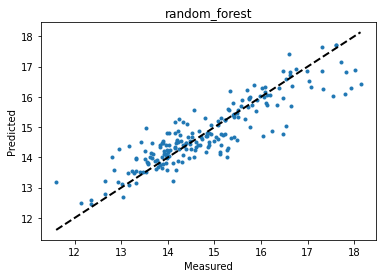

,random_forest
rmse,0.579539
r2,0.79289
preprocessing__num_preprocessing__normalizer,passthrough
preprocessing__num_preprocessing__scaler,StandardScaler()
preprocessing__remainder,passthrough


In [32]:
target='site_energy_use_wn_log'
skip_features=['energystar_score', 'site_energy_use_wn']

num_features = df_site_energy_use_wn.columns[~df_site_energy_use_wn.columns.str.contains('cat_')]
num_features = num_features[~np.isin(num_features, [target]+skip_features)].tolist()

num_preprocessing = Pipeline((
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('normalizer', 'passthrough'),
    ('scaler', 'passthrough')
), verbose = False)

preprocessing = ColumnTransformer([('num_preprocessing', num_preprocessing, num_features)])

models_dict = {'random_forest':{
    'model': RandomForestRegressor(random_state = seed),
    'param_grid': {},
    },
}

preprocessing_param_grid = {
    'preprocessing__remainder': ['passthrough', 'drop'],
    'preprocessing__num_preprocessing__normalizer': ['passthrough', FunctionTransformer(lambda x: np.log(np.abs(x)+1))],
    'preprocessing__num_preprocessing__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
}

best_estimator_site_energy_use_wn = model_selection(
    df_site_energy_use_wn, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    preprocessing_param_grid=preprocessing_param_grid,
    random_state=seed,
    test_size=0.1,
    chart=True
)

### Fine tunning

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.4min finished


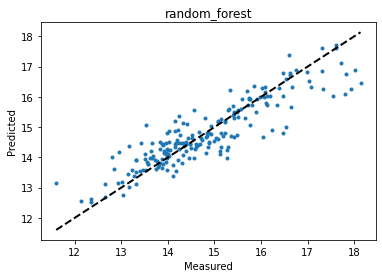

,random_forest
rmse,0.577631
r2,0.794251
model__max_depth,None
model__max_features,auto
model__n_estimators,300


CPU times: user 1min 23s, sys: 1.44 s, total: 1min 25s
Wall time: 1min 32s


In [33]:
%%time
target='site_energy_use_wn_log'
skip_features=['energystar_score', 'site_energy_use_wn']

models_dict = {'random_forest': {
    'model': RandomForestRegressor(random_state = seed),
    'param_grid': {'model__n_estimators': [50, 100, 300],
                   'model__max_depth': [6, None], 
                   'model__max_features':['auto', 'sqrt', 'log2']
                  }}}

best_estimator_site_energy_use_wn = model_selection(
    df_site_energy_use_wn, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=best_estimator_site_energy_use_wn.best_estimator_['preprocessing'],
    models_dict=models_dict,
    random_state=seed,
    test_size=0.1,
    chart=True,
    verbosity=1
)

### Feature importance

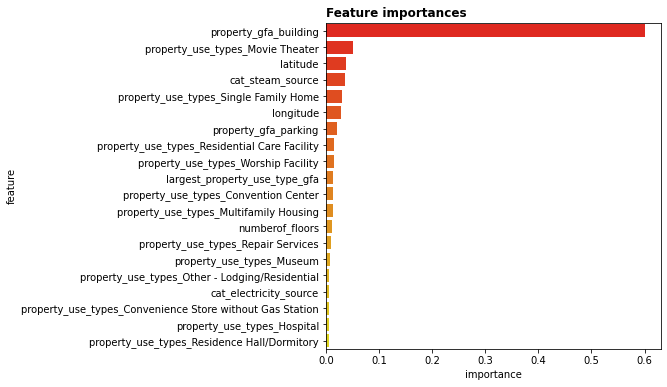

In [38]:
X_train, X_test, y_train, y_test = data_selection(df_site_energy_use_wn, target, skip_features)
feature_importances = pd.DataFrame({'feature':X_train.columns, 'importance': best_estimator_site_energy_use_wn.best_estimator_['model'].feature_importances_})

plt.figure(figsize=(6, 6))
sns.barplot('importance', 'feature', data=feature_importances.sort_values('importance', ascending = False).iloc[:20], palette='autumn')
plt.title('Feature importances', loc='left', weight='bold')
plt.show()

### Error analysis

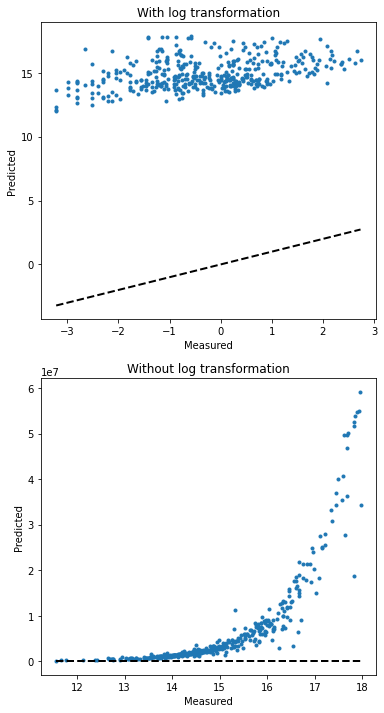

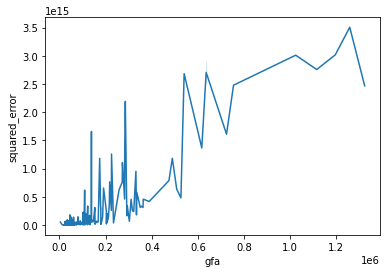

In [35]:
target='site_energy_use_wn_log'
skip_features=['energystar_score', 'site_energy_use_wn']
X_train, X_test, y_train, y_test = data_selection(df_site_energy_use_wn, target, skip_features)

y_pred_log = pd.Series(best_estimator_site_energy_use_wn.best_estimator_.predict(X_test_log))
y_pred = np.exp(y_pred_log)

gfa = X_test.property_gfa_building.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_test_log = y_test_log.reset_index(drop=True)

results_df = pd.concat([y_test, y_test_log, y_pred, y_pred_log, gfa], axis=1, ignore_index=True)
results_df.columns = ['test', 'test_log', 'pred', 'pred_log', 'gfa']
results_df.sort_values('test', inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(6, 12))
ax[0].scatter(results_df.test_log, results_df.pred_log, marker='.')
ax[0].plot([results_df.test_log.min(), results_df.test_log.max()], [results_df.test_log.min(), results_df.test_log.max()], 'k--', lw=2)
ax[0].set_xlabel('Measured')
ax[0].set_ylabel('Predicted')
ax[0].title.set_text('With log transformation')

ax[1].scatter(results_df.test, results_df.pred, marker='.')
ax[1].plot([results_df.test.min(), results_df.test.max()], [results_df.test.min(), results_df.test.max()], 'k--', lw=2)
ax[1].set_xlabel('Measured')
ax[1].set_ylabel('Predicted')
ax[1].title.set_text('Without log transformation')

plt.show()

results_df['squared_error_log'] = (results_df.pred_log - results_df.test_log) ** 2
results_df['squared_error'] = (results_df.pred - results_df.test) ** 2
sns.lineplot(x = 'gfa', y= 'squared_error', data = results_df.sort_values('gfa'))
plt.show()

### With energy star score

In [36]:
df_site_energy_use_wn_energystar_score = df_site_energy_use_wn.loc[df_site_energy_use_wn.energystar_score.notna()]
df_site_energy_use_wn_energystar_score.shape

(1360, 97)

In [37]:
models_dict = {'random_forest':{'model': best_estimator_site_energy_use_wn.best_estimator_['model'], 'param_grid': {}}}

model = model_selection(
    df_site_energy_use_wn_energystar_score, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=best_estimator_site_energy_use_wn.best_estimator_['preprocessing'],
    models_dict=models_dict,
    preprocessing_param_grid={},
    random_state=seed,
    chart=False,
    verbosity=1
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.9s finished


,random_forest
rmse,0.588411
r2,0.763331
